In [376]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [377]:
#Constantes

L = 2 #[m]
dL= 0.1
q = 400 # [W/m^3]
Ta = 258.15 # [Kelvin]
i = 200 # Nombre de pas du maillage spatial [s]
dx=L/i; #Pas de discrétisation
ti = 0 # temps initial [s]
tf = 10**7 # temps final [s]

k = 0.5 # [W/(m*K)]
h = 20 # [W/(m^2*K)]
Xi = 0.5 # [S.U.]
Cv = 1000 # [J/(Kg*K)]
rho = 2000 # [Kg/m^3]
dt = dx**2*((Cv*rho)/k) # pas de temps [s]

In [378]:
#Conditions frontieres
# à x=0 : c1*T'(0)+c2*T(0) + c3 = 0 ; à x=L d1*T'(L) + d2*T(L) + d3 = 0
c1, c2, c3 = -k, h, -h*Ta
d1, d2, d3 = -k, -h, h*Ta

In [379]:
#Initialisations des matrices
S=np.zeros(i+1,dtype=np.double)
A=np.diag(-2*np.ones(i+1),0)+np.diag(np.ones(i),-1)+np.diag(np.ones(i),1)
b=np.zeros(i+1,dtype=np.double)
u=np.zeros(i+1,dtype=np.double)

#Source
x=np.linspace(0,L,i+1)
S=(q*np.exp(-x/dL))/k
u0=np.full(i+1,Ta,dtype=np.double)

#Conditions frontieres dans la matrice A
A[0, 0], A[0, 1], A[0, 2] = (2*c2 *dx -3*c1)*Xi, 4*c1*Xi, -c1*Xi
A[i, i-2], A[i, i-1], A[i, i] = d1*Xi, -4*d1*Xi, (2*d2*dx+3*d1)*Xi

#Vecteur b et conditions frontieres
b=-S*dx**2
b[0]=-2*c3*dx-(2*c2*dx-3*c1)*(1-Xi)*u0[0]-4*c1*(1-Xi)*u0[1]+c1*(1-Xi)*u0[2] 
b[i]=-2*d3*dx-d1*(1-Xi)*u0[i-2]+4*d1*(1-Xi)*u0[i-1]-(2*d2*dx+3*d1)*(1-Xi)*u0[i]

#Matrice M
M=np.diag(np.ones(i+1))
M[0,0]=0
M[i,i]=0

#A' et B'
alpha = (Cv*rho)/k
A_prime = M-(dt/(alpha*dx**2))*Xi*A
b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@u0-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)

In [380]:
print(A.shape)

(201, 201)


In [381]:
#Resolution temporelle

t=ti
T_max=[Ta]
ci=1
time_list=[0]

while t<tf:
    
    ci+=1
    u=np.linalg.solve(A_prime,b_prime)
    T_max.append(u.max())
    b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@u-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)
    time_list.append(t)
    t=t+dt





In [382]:
#Calcul du temps d'équilibre
T_max_K = np.array(T_max) 

T0 = T_max_K[0]
T_eq = T_max_K[-1]

threshold = T0 + 0.95 * (T_eq - T0)

mask = T_max_K >= threshold

if np.any(mask):
    idx = np.argmax(mask)
    tau_eq = time_list[idx]
    print(f"Temps d'équilibrage τ_eq = {tau_eq:.3e} s")
else:
    print("Le seuil d'équilibre n'a pas été atteint pendant la simulation.")

print(f"T0 = {T0-273.15:.5f}, T_eq = {T_eq-273.15:.5f}, threshold = {threshold-273.15:.5f}")
print(f"Max atteint = {np.max(T_max_K)-273.15:.5f}")

Temps d'équilibrage τ_eq = 3.218e+06 s
T0 = -15.00000, T_eq = -6.99412, threshold = -7.39441
Max atteint = -6.99412


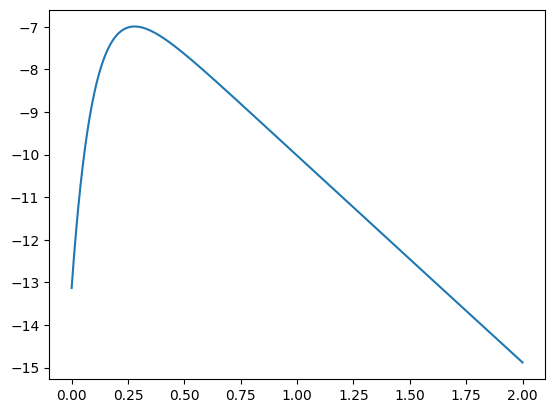

In [ ]:
#Graphique

x=np.linspace(0,L,len(u))
u=u-273.15
plt.plot(x,u)
